In [6]:
# PNC

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/PNC_Good/AngleBasis1.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
fc = []
sex = []
race = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
    m = re.search('([^-]+)-(.*)', subtask)
    sub = m.group(1)
    task = m.group(2)
    a = demo['age_at_cnb'][sub]
    age.append(a)
    s = demo['Sex'][sub] == 'M'
    r = demo['Race'][sub] == 'AA'
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-{task}_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age)
fc = np.stack(fc)
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')

print([a.shape for a in [thetas, jitter, age, sex, race, fc]])
print(np.mean(age))

[(3849, 1, 264), (3849, 1, 264), (3849,), (3849,), (3849,), (3849, 34716)]
14.398285268901013


In [22]:
# BSNIP

import pickle
import re
import numpy as np

basis_file = '/home/anton/Documents/Tulane/Research/BSNIP/AngleBasisLong5.pkl'
demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'

basis = pickle.load(open(basis_file, 'rb'))

thetas = []
jitter = []
age = []
sex = []
race = []
sz = []
fc = []

demo = pickle.load(open(f'{demodir}/demographics.pkl', 'rb'))

for subtask in basis:
#     m = re.search('([^-]+)-(.*)', subtask)
    m = re.search('([^-]+)', subtask)
    sub = m.group(1)
#     task = m.group(2)
    a = demo['Age_cal'][sub]
    s = demo['sex'][sub] == 's1.0'
    r = demo['Race'][sub] == 'AA'
    z = demo['DXGROUP_2'][sub] == 'SZP'
    if demo['DXGROUP_2'][sub] not in ['SZP', 'NC', 'SZR', 'SADR', 'BPR', 'BPP', 'SADP']:
        continue
    age.append(a)
    sz.append(z)
    sex.append(s)
    race.append(r)
    thetas.append(basis[subtask]['thetas'])
    jitter.append(basis[subtask]['jitter'])
    p = np.load(f'{demodir}/fc/{sub}_task-unk_fc.npy')
    fc.append(p)
    
thetas = np.stack(thetas)
jitter = np.stack(jitter)
age = np.array(age).astype('int')
sex = np.array(sex).astype('int')
race = np.array(race).astype('int')
sz = np.array(sz).astype('int')
fc = np.stack(fc)

print([a.shape for a in [thetas, jitter, sex, race, sz, age, fc]])
print(np.mean(1-sex))
print(np.mean(1-race))
print(np.mean(1-sz))
print(np.mean(age))

[(1244, 5, 264), (1244, 5, 264), (1244,), (1244,), (1244,), (1244,), (1244, 34716)]
0.5763665594855305
0.6889067524115756
0.840032154340836
38.209807073954984


In [23]:
def rmse(yhat, y):
    if isinstance(yhat, np.ndarray) or isinstance(yhat, int):
        f = np.mean
    else:
        f = torch.mean
    return f((y-yhat)**2)**0.5

def tops(thetas, jitter):
    t0 = np.expand_dims(thetas, 2)
    t1 = np.expand_dims(thetas, 3)
    j0 = np.expand_dims(jitter, 2)
    j1 = np.expand_dims(jitter, 3)
    ps = np.cos(t0-t1)*(j0*j1)
    a,b = np.triu_indices(264, 1)
    ps = ps[:,:,a,b]
    return ps
    
ps = tops(thetas, jitter)
aps = np.mean(ps, axis=1)
res = fc - aps

print(ps.shape)
print(aps.shape)
print(res.shape)

(1244, 5, 34716)
(1244, 34716)
(1244, 34716)


In [24]:
aps5 = aps
res5 = res

print('Done')

Done


In [19]:
# Try partial correlation

from nilearn.connectome import ConnectivityMeasure

def cat(x, **kwargs):
    return np.concatenate(x, **kwargs)

rest_ts = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_rest_good_filt.pkl', 'rb'))
nback_ts = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_nback_good_filt.pkl', 'rb'))
emoid_ts = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_emoid_good_filt.pkl', 'rb'))

pc = []
con = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)

for i,subtask in enumerate(basis):
    m = re.search('([^-]+)-(.*)', subtask)
    sub = m.group(1)
    task = m.group(2)
    if task == 'rest':
        ts = rest_ts
    elif task == 'nback':
        ts = nback_ts
    elif task == 'emoid':
        ts = emoid_ts
    p = con.fit_transform([ts[sub].T])
    pc.append(p)
    if i%100 == 0:
        print(f'Finished {i}')
    
pc = cat(pc)
print(pc.shape)

Finished 0
Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished 700
Finished 800
Finished 900
Finished 1000
Finished 1100
Finished 1200
Finished 1300
Finished 1400
Finished 1500
Finished 1600
Finished 1700
Finished 1800
Finished 1900
Finished 2000
Finished 2100
Finished 2200
Finished 2300
Finished 2400
Finished 2500
Finished 2600
Finished 2700
Finished 2800
Finished 2900
Finished 3000
Finished 3100
Finished 3200
Finished 3300
Finished 3400
Finished 3500
Finished 3600
Finished 3700
Finished 3800
(3849, 34716)


In [4]:
from sklearn.decomposition import PCA, FactorAnalysis

# pca = PCA(n_components=1).fit(fc)
# fc_comp = pca.transform(fc)
# fc_low = pca.inverse_transform(fc_comp)

fa = FactorAnalysis(n_components=10).fit(fc)
fa_low = fa.transform(fc)@fa.components_
fa_res = fc-fa_low

print(fa_res.shape)

(441, 34716)


In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def fromnp(x):
    return torch.from_numpy(x).float().cuda()

def tonp(x):
    return x.detach().cpu().numpy()

def absmean(x):
    return torch.mean(torch.abs(x))

class LR():
    def __init__(self, C=1):
        self.C = C
        
    def logits(self, x):
        z = torch.einsum('na,a->n', x, self.w)
        return z
    
    def torch_proba(self, x):
        z = self.logits(x)
        p = 1/(1+torch.exp(-z))
        return p
    
    def predict_proba(self, x):
        if isinstance(x, np.ndarray):
            x = fromnp(x)
        p = self.torch_proba(x)
        p = tonp(p)
        p = np.stack([1-p, p], axis=1)
        return p
    
    def predict(self, x):
        p = self.predict_proba(x)
        return np.argmax(p, axis=1)
    
    def grad(self, x, y):
        yp = (2*y-1).unsqueeze(1)
        z = self.logits(x)
        a = -yp*x
        b = (yp*z.unsqueeze(1))
        return torch.mean(a/(1+torch.exp(b)), axis=0)
    
    def reg(self):
        return self.C*1e-8*self.w
    
    def loss(self, x, y):
        p = self.torch_proba(x)
        return -torch.mean(y*torch.log(p+1e-8)+(1-y)*torch.log(1-p+1e-8))
    
    def coef_(self):
        return tonp(self.w)
    
    def fit(self, x, y, nepochs=5000, pperiod=100, lr=1e-3, verbose=False):
        xtr = fromnp(x)
        ytr = fromnp(y)
        dim = xtr.shape[1]
        self.w = dim**-0.5*torch.randn(dim).float().cuda()
        for e in range(nepochs):
            grad = self.grad(xtr, ytr)
            self.w -= lr*grad + self.reg()
            if not verbose:
                continue
            if e == nepochs-1 or e % pperiod == 0:
                loss = self.loss(xtr, ytr)
                print(f'{e} {float(loss)} {float(absmean(self.reg()))}')
        return self

print('Complete')

Complete


In [4]:
import sys

pth = '../../LatentSimilarity/'

if pth not in sys.path:
    sys.path.append(pth)
    
print(sys.path)

['/home/anton/Documents/Tulane/Research/code/LowRank', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/anton/.local/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '../../LatentSimilarity/']


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from latsim import LatSimClf
import warnings
warnings.filterwarnings("ignore")

# wdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/weights/'

# def savew(i, typ, acc, trsubi, tsubi, w):
#     trsubs = [subs[j] for j in trsubi]
#     tsubs = [subs[j] for j in tsubi]
#     desc = f'Logistic regression {typ} acc: {acc}'
#     obj = dict(w=w.squeeze(), trsubs=trsubs, tsubs=tsubs, desc=desc)
#     with open(f'{wdir}/{typ}-race/lr{i}.pkl', 'wb') as f:
#         pickle.dump(obj, f)

def cat(x, **kwargs):
    return np.concatenate(x, **kwargs)

rmsefc = []
rmseens = []

for i in range(10):

    idcs = np.arange(fc.shape[0])
    x0 = aps5#[:500]#[idcs[:1244]]
    x1 = res1#[:500]#[idcs[:1244]]
    x2 = fc#fc#[:500]#[idcs[:1244]]
    x = cat([x0, x1, x2], axis=1)
    y = sex#[:500]#[idcs[:1244]]

    xtr, xt, ytr, yt, trsubi, tsubi = train_test_split(x, y, idcs, stratify=y, train_size=0.8)
    
    n = 34716

    xlst = [(xtr[:,a*n:(a+1)*n], xt[:,a*n:(a+1)*n]) for a in range(0,3)]
    xtr0, xt0, xtr1, xt1, xtr2, xt2 = [a for b in xlst for a in b]

    reg = LatSimClf(nepochs=1000).fit(xtr0, ytr) #LogisticRegression(C=100, max_iter=100).fit(xtr0, ytr)
    yhat0 = reg.predict(xt0)
    print(np.mean(yhat0 == yt))
    p0 = reg.predict_proba(xt0)
#     savew(i, 'aps5', np.mean(yhat0 == yt), trsubi, tsubi, reg.coef_)
    
    reg = LatSimClf(nepochs=1000).fit(xtr1, ytr) #LogisticRegression(C=100, max_iter=100).fit(xtr1, ytr)
    yhat1 = reg.predict(xt1)
    print(np.mean(yhat1 == yt))
    p1 = reg.predict_proba(xt1)
#     savew(i, 'res1', np.mean(yhat1 == yt), trsubi, tsubi, reg.coef_)
    
    reg = LatSimClf(nepochs=1000).fit(xtr2, ytr) #LogisticRegression(C=100, max_iter=100).fit(xtr2, ytr)
    yhat2 = reg.predict(xt2)
    print(np.mean(yhat2 == yt))
#     savew(i, 'fc', np.mean(yhat2 == yt), trsubi, tsubi, reg.coef_)
    
    p = (p0+p1)/2
    yhat = np.argmax(p, axis=-1)
    print(np.mean(yhat == yt))
    print(np.mean(1-yt))
    print(f'{i} ----')
    
    rmsefc.append(np.mean(yhat2 == yt))
    rmseens.append(np.mean(yhat == yt))
    
print(np.mean(rmsefc), np.std(rmsefc))
print(np.mean(rmseens), np.std(rmseens))

0.678714859437751
0.751004016064257
0.7429718875502008
0.7469879518072289
0.5783132530120482
0 ----
0.6546184738955824
0.678714859437751
0.6385542168674698
0.7228915662650602
0.5783132530120482
1 ----
0.6907630522088354
0.6907630522088354
0.7269076305220884
0.7389558232931727
0.5783132530120482
2 ----
0.6546184738955824
0.6706827309236948
0.7188755020080321
0.6746987951807228
0.5783132530120482
3 ----
0.6907630522088354
0.6947791164658634
0.6987951807228916
0.7228915662650602
0.5783132530120482
4 ----
0.6827309236947792
0.678714859437751
0.714859437751004
0.714859437751004
0.5783132530120482
5 ----
0.6706827309236948
0.7389558232931727
0.7349397590361446
0.7349397590361446
0.5783132530120482
6 ----
0.6947791164658634
0.7349397590361446
0.7188755020080321
0.7389558232931727
0.5783132530120482
7 ----
0.678714859437751
0.5903614457831325
0.7269076305220884
0.6947791164658634
0.5783132530120482
8 ----
0.6506024096385542
0.7269076305220884
0.7068273092369478
0.7429718875502008
0.57831325301

In [22]:
wdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/test/weights/fc-age'
weights = pickle.load(open(f'{wdir}/lstsq-emoid19.pkl', 'rb'))

print(weights.keys())
print(weights['w'].shape)
print(len(weights['tsubs']))
print(weights['desc'])
print(reg.coef_.squeeze().shape)

dict_keys(['w', 'trsubs', 'tsubs', 'desc'])
(34716,)
480
age prediction full model lstsq fc rmse: 30.305448532104492
(34716,)


/tmp/ipykernel_2558168/3046087273.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


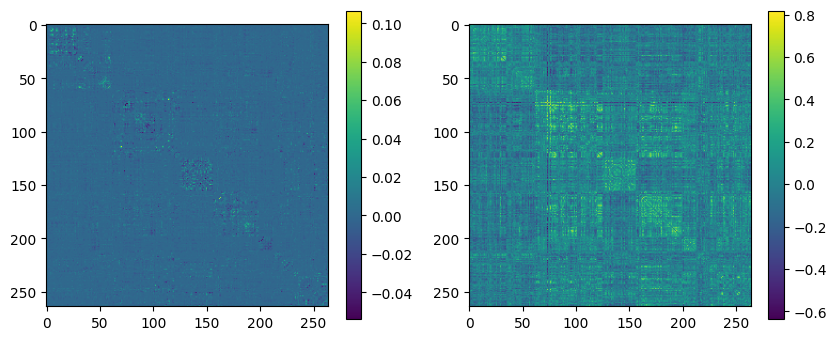

In [150]:
import matplotlib.pyplot as plt

num = 600

fig, ax = plt.subplots(1,2,figsize=(10,4))
# im0 = ax[0].imshow(remap(vec2mat(reg.coef_)))
im0 = ax[0].imshow(remap(vec2mat(reg.coef_[0]*np.mean(res1, axis=0))))
im1 = ax[1].imshow(remap(vec2mat(res1[num])))
fig.colorbar(im0)
fig.colorbar(im1)
fig.show()

[18907 19953 19260 26332 22404] [ 6522 19495 25319  9965  9964]
[ 9964 34563 31146 10406     0] [28721 28519 10650 30346 28058]


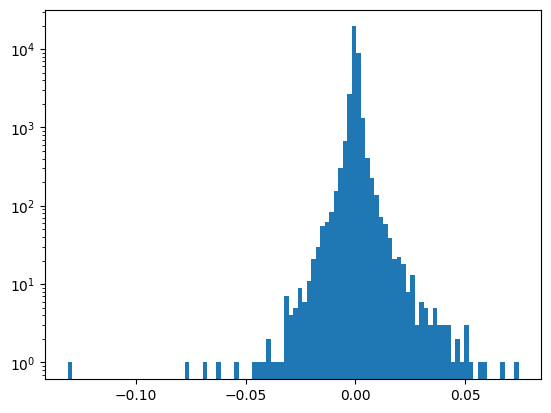

In [300]:
z = np.mean(res1, axis=0)
idcs = np.argsort(z)
print(idcs[0:5], idcs[-5:])
z = reg.coef_[0]*np.mean(res1, axis=0)
idcs = np.argsort(z)
print(idcs[0:5], idcs[-5:])
plt.hist(z, log=True, bins=100)
plt.show()

In [292]:
a,b = np.triu_indices(264,1)
print(a[3339],b[3339])
print(a[9964],b[9964])
print(a[9965],b[9965])

12 262
41 43
41 44


In [149]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete
